In [2]:
import pandas as pd
import numpy as np
from craigslist import CraigslistHousing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re


sns.set_style("darkgrid", {"axes.facecolor": ".95"})

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
cl = CraigslistHousing(site='newyork', category='abo')
results = cl.get_results(limit = 2500, sort_by='newest')

In [4]:
data = pd.DataFrame(results)

In [5]:
data.head(3)

,datetime,geotag,has_image,has_map,id,name,num_bed,price,sq_feet,url,where
0,2016-09-09 04:29,None,True,True,5773241351,Prime location~~LOFT~~3 br 2 baths~~No fee~~(G...,3,$4495,None,http://newyork.craigslist.org/brk/abo/57732413...,CLINTON HILL
1,2016-09-09 04:27,None,True,True,5773259437,Apartment for rent,3,$1950,None,http://newyork.craigslist.org/que/abo/57732594...,Ozono Park
2,2016-09-09 04:17,None,False,False,5773252319,"Dobbs Ferry sun filled, river views, steps to ...",3,$2500,None,http://newyork.craigslist.org/wch/abo/57732523...,dobbs ferry village


In [17]:
def clean_data(data):
    data.datetime = pd.to_datetime(data.datetime)
    data["sq_feet"] = data["sq_feet"].astype(float)
    
    data = (data.dropna(subset = ["price"]) # eliminate things with no price
                .assign(price = data["price"].str.lstrip("$").astype(float)) #make the price numeric
                .query("price > 100 & price < 15000") #eliminate crazy prices
                .assign(name = data["name"].str.replace("/", " ")) #replace "/" with " "
                .assign(hour = data["datetime"].dt.hour, #extract time feats
                        dayofweek = data["datetime"].dt.dayofweek))
    
    data.loc[data["num_bed"].isin(["5", "6", "7", "8"]), "num_bed"] = "5 or more" #coalesce high num_bed
    
    data["name"] = data["name"].str.lower()
    data.loc[data["name"].str.contains("[Ss]tudio"), "num_bed"] = "Studio" #if num_bed is unknown and contains studio
    
    data["where"] = (data["where"].str.lower()
                                  .str.replace('[^\w\s]','')
                                  .str.replace("no fee", "")
                                  .str.replace(" ",""))

    
    loc_count = data["where"].value_counts() #reducing levels
    mask = data["where"].isin(loc_count[loc_count < 5].index)
    data.ix[mask, "where"] = "other" #replace  rare locations with "other"
    
    data["int_bed"] = data["num_bed"] #creating price per bedroom feat:
    data.loc[data.int_bed == "Studio", "int_bed"] = 1
    data.loc[data.int_bed == "5 or more", "int_bed"] = 5
    data["int_bed"] = data["int_bed"].astype(float)
    data["per_person"] = data["price"]/data["int_bed"]
    
    
    return(data)

In [18]:
data = clean_data(data)

In [109]:
data = data.query("price > 100 & price < 12000")
data["where"] = data["where"].str.lower()

In [6]:
data.shape

(2500, 11)

In [7]:
data.isnull().sum(0)

datetime        0
geotag       2500
has_image       0
has_map         0
id              0
name            0
num_bed       245
price           0
sq_feet      1951
url             0
where         129
dtype: int64

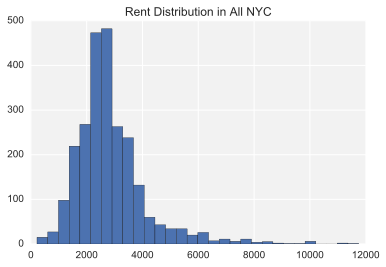

In [61]:
data.price.hist(bins = 30)
plt.title("Rent Distribution in All NYC")# right skewed.

In [62]:
data.price.median()

2690.0

In [63]:
#per capita:

data["int_bed"] = data["num_bed"]
data.loc[data.int_bed == "Studio", "int_bed"] = 1
data.loc[data.int_bed == "5 or more", "int_bed"] = 5

data["int_bed"] = data["int_bed"].astype(float)

In [64]:
data["per_person"] = data["price"]/data["int_bed"]

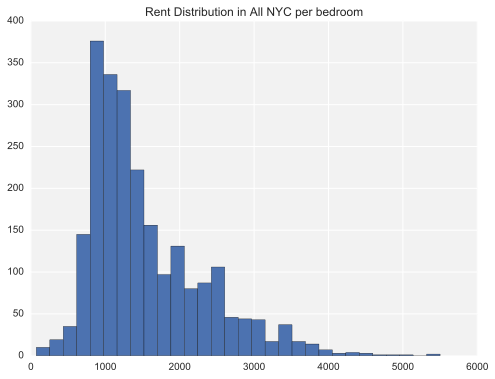

In [83]:
data.per_person.hist(bins = 30)
plt.title("Rent Distribution in All NYC per bedroom")# right skewed.

In [66]:
data.per_person.mean()

1540.793713760428

In [67]:
data.per_person.median()

1300.0

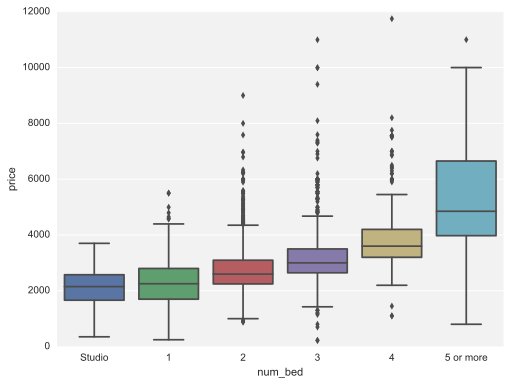

In [84]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

sns.boxplot(x = "num_bed", y = "price", data = data, order = ["Studio", "1", "2", "3", "4", "5 or more"])

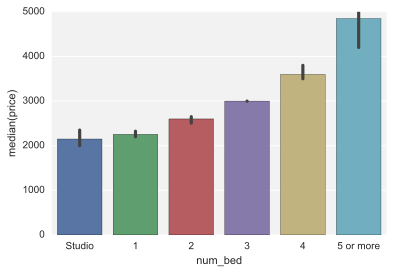

In [75]:
sns.barplot(x = "num_bed", y = "price", data = data, estimator = np.median,
            order = ["Studio", "1", "2", "3", "4", "5 or more"])

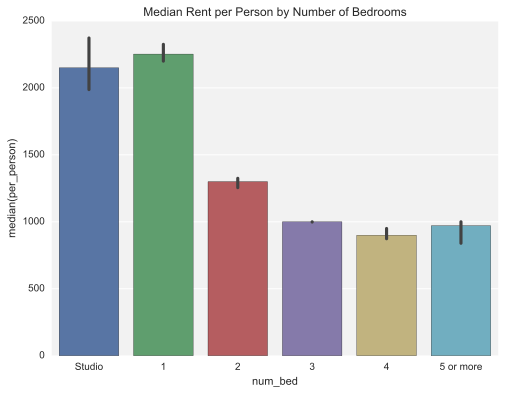

In [95]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

sns.barplot(x = "num_bed", y = "per_person", estimator = np.median,
            data = data, order = ["Studio", "1", "2", "3", "4", "5 or more"])
plt.title("Median Rent per Person by Number of Bedrooms")

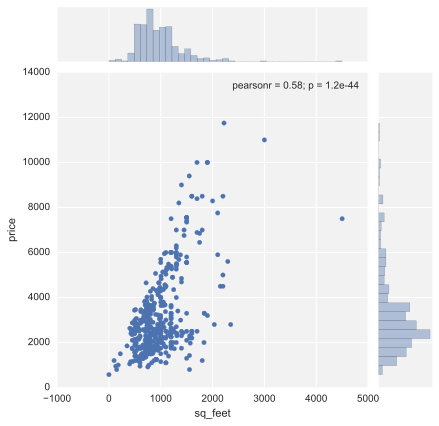

In [85]:
sns.jointplot(x = "sq_feet", y = "price", data=data)

(0, 12000)

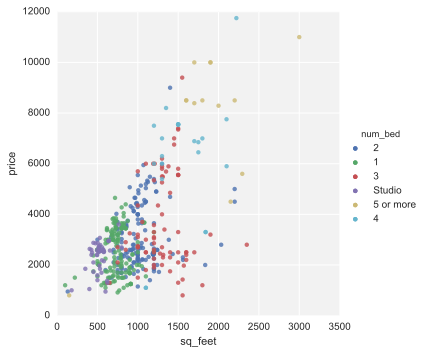

In [87]:
plt.figure(figsize=(12,12))
sns.lmplot(x = "sq_feet", y = "price", data=data, hue="num_bed", fit_reg=False)
plt.xlim(0, 3500)
plt.ylim(0, 12000)

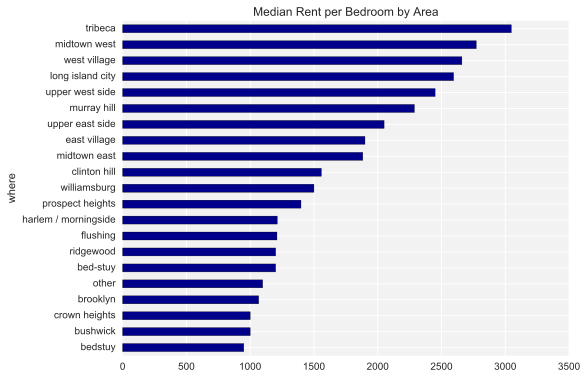

In [115]:
price_by_locations = (data.groupby("where")["per_person"]
                          .aggregate(["median", "count"])
                          .query("count > 15")
                          .sort_values("median"))
price_by_locations["median"].plot.barh(title = "Median Rent per Bedroom by Area", color = "darkblue")

In [25]:
data.head(20)

,datetime,geotag,has_image,has_map,id,name,num_bed,price,sq_feet,url,where
0,2016-09-09 04:29,None,True,True,5773241351,Prime location~~LOFT~~3 br 2 baths~~No fee~~(G...,3,$4495,None,http://newyork.craigslist.org/brk/abo/57732413...,CLINTON HILL
1,2016-09-09 04:27,None,True,True,5773259437,Apartment for rent,3,$1950,None,http://newyork.craigslist.org/que/abo/57732594...,Ozono Park
2,2016-09-09 04:17,None,False,False,5773252319,"Dobbs Ferry sun filled, river views, steps to ...",3,$2500,None,http://newyork.craigslist.org/wch/abo/57732523...,dobbs ferry village
3,2016-09-09 04:13,None,True,True,5773242392,Large 1 bedroom in grand concourse,1,$821,None,http://newyork.craigslist.org/brx/abo/57732423...,grand concourse
4,2016-09-09 04:07,None,True,True,5773241684,Grab this great deal right away!,1,$1295,None,http://newyork.craigslist.org/que/abo/57732416...,Woodside
5,2016-09-09 04:06,None,False,False,5773265421,"Brownstone, large sunny renovated floor throug...",3,$5999,None,http://newyork.craigslist.org/mnh/abo/57732654...,Upper West Side
6,2016-09-09 04:04,None,True,True,5773229185,LARGE 1BR/1BA in TriBeCA/Lundry/Elevator/Locat...,1,$4295,None,http://newyork.craigslist.org/mnh/abo/57732291...,TriBeCa
7,2016-09-09 03:53,None,True,True,5773222560,The best deal in the area 5Br 3Baths no fee pe...,5,$4196,None,http://newyork.craigslist.org/brk/abo/57732225...,Bushwick / Ridgewood
8,2016-09-09 03:52,None,False,False,5773230410,A deluxe two bedroom with sizeable floor plan!,1,$1260,None,http://newyork.craigslist.org/brx/abo/57732304...,Woodlawn Heights
9,2016-09-09 03:47,None,True,True,5773221634,Elevator BLDG + W/D In Unit + Central A/C & He...,3,$4200,None,http://newyork.craigslist.org/brk/abo/57732216...,Williamsburg


In [13]:
titles = data.name.str.replace("[^\w\s]", "").str.lower()

In [22]:
titles.head(20)

0           prime locationloft3 br 2 bathsno feeg train
1                                    apartment for rent
2       dobbs ferry sun filled river views steps to all
3                    large 1 bedroom in grand concourse
4                       grab this great deal right away
5     brownstone large sunny renovated floor through...
6     large 1br1ba in tribecalundryelevatorlocationr...
7     the best deal in the area 5br 3baths no fee pe...
8         a deluxe two bedroom with sizeable floor plan
9     elevator bldg  wd in unit  central ac  heat  r...
10        a deluxe two bedroom with sizeable floor plan
11    need to move asap move in today easy approval ...
12    loaded waterfront 3bedroom  parking laundry an...
13              newly renovated 2bedroom in castle hill
14    luxury 2 bd w office ac  heat roof access asap...
15                large renovated 1bedroom in wakefield
16            sunny petfriendly 4bedroom in morris park
17    entire large 4bedroom house for rent in mo

In [28]:
data["bedroomz"]= titles.str.extract("(\d)\s?bdr|br|bedroom")

In [38]:
 titles.str.extract("(\d+)(\s?-?)(bdr|br|bed|bd)")[0]

0         3
1       NaN
2       NaN
3         1
4       NaN
5       NaN
6         1
7         5
8       NaN
9       NaN
10      NaN
11      NaN
12        3
13        2
14        2
15        1
16        4
17        4
18      NaN
19      NaN
20      NaN
21        2
22        2
23      NaN
24        2
25        3
26        1
27      NaN
28        1
29        1
       ... 
2470      1
2471    NaN
2472    NaN
2473      1
2474      3
2475      3
2476      3
2477      2
2478      1
2479      1
2480      4
2481      3
2482    NaN
2483      4
2484      1
2485      3
2486      3
2487      1
2488      2
2489      1
2490      4
2491      1
2492      3
2493      3
2494    NaN
2495      3
2496      2
2497      2
2498      4
2499      2
Name: 0, dtype: object

In [41]:
data["bedroomz"] = titles.str.extract("(\d|two|one|three)(\s?-?)(bd|br|bed)")[0]

In [42]:
data

,datetime,geotag,has_image,has_map,id,name,num_bed,price,sq_feet,url,where,bedroomz
0,2016-09-09 04:29,None,True,True,5773241351,Prime location~~LOFT~~3 br 2 baths~~No fee~~(G...,3,$4495,None,http://newyork.craigslist.org/brk/abo/57732413...,CLINTON HILL,3
1,2016-09-09 04:27,None,True,True,5773259437,Apartment for rent,3,$1950,None,http://newyork.craigslist.org/que/abo/57732594...,Ozono Park,NaN
2,2016-09-09 04:17,None,False,False,5773252319,"Dobbs Ferry sun filled, river views, steps to ...",3,$2500,None,http://newyork.craigslist.org/wch/abo/57732523...,dobbs ferry village,NaN
3,2016-09-09 04:13,None,True,True,5773242392,Large 1 bedroom in grand concourse,1,$821,None,http://newyork.craigslist.org/brx/abo/57732423...,grand concourse,1
4,2016-09-09 04:07,None,True,True,5773241684,Grab this great deal right away!,1,$1295,None,http://newyork.craigslist.org/que/abo/57732416...,Woodside,NaN
5,2016-09-09 04:06,None,False,False,5773265421,"Brownstone, large sunny renovated floor throug...",3,$5999,None,http://newyork.craigslist.org/mnh/abo/57732654...,Upper West Side,NaN
6,2016-09-09 04:04,None,True,True,5773229185,LARGE 1BR/1BA in TriBeCA/Lundry/Elevator/Locat...,1,$4295,None,http://newyork.craigslist.org/mnh/abo/57732291...,TriBeCa,1
7,2016-09-09 03:53,None,True,True,5773222560,The best deal in the area 5Br 3Baths no fee pe...,5,$4196,None,http://newyork.craigslist.org/brk/abo/57732225...,Bushwick / Ridgewood,5
8,2016-09-09 03:52,None,False,False,5773230410,A deluxe two bedroom with sizeable floor plan!,1,$1260,None,http://newyork.craigslist.org/brx/abo/57732304...,Woodlawn Heights,two
9,2016-09-09 03:47,None,True,True,5773221634,Elevator BLDG + W/D In Unit + Central A/C & He...,3,$4200,None,http://newyork.craigslist.org/brk/abo/57732216...,Williamsburg,NaN


In [45]:
titles.str.replace("(\d|two|one|three)(\s?-?)(bd|br|bed)", "")

0                 prime locationloft 2 bathsno feeg train
1                                      apartment for rent
2         dobbs ferry sun filled river views steps to all
3                           large room in grand concourse
4                         grab this great deal right away
5       brownstone large sunny renovated floor through...
6       large 1ba in tribecalundryelevatorlocationreno...
7       the best deal in the area  3baths no fee perfe...
8                  a deluxe room with sizeable floor plan
9       elevator bldg  wd in unit  central ac  heat  r...
10                 a deluxe room with sizeable floor plan
11      need to move asap move in today easy approval ...
12      loaded waterfront room  parking laundry and ba...
13                    newly renovated room in castle hill
14        luxury  w office ac  heat roof access asap move
15                      large renovated room in wakefield
16                  sunny petfriendly room in morris park
17        enti